# Project overview
This project aims to use nn regression to figure out how input features influence output feature and reflect dependence of output on input

## Data base
All the data were generated by MATLAB simulation. Each row is a node and columns are the features on such node, for example, $A_{1,1}$ is Mesh label 1 of first node of mesh file 1.
Every 100 row mean one specific mesh file, for example, rows $1-100$ mean mesh file 1, rows $101-200$ mean mesh file 2.etc. Frist 5 colomns are mesh labels.

Here's all the data features:

<style>
  table {
    border-collapse: collapse;
    width: 100%;
    font-family: Arial, sans-serif;
    text-align: center;
  }
  th, td {
    border: 1px solid #999;
    padding: 6px 10px;
  }
  th {
    background-color: #f2f2f2;
  }
</style>

<table>
  <tr>
    <th>Col0</th><th>Col1</th><th>Col2</th><th>Col3</th><th>Col4</th>
  </tr>
  <tr>
    <td>Diameter</td><td>w_ip</td><td>w_p</td><td>amplitude</td><td>ip_hight</td>
  </tr>
  <tr>
    <th>Col5</th><th>Col6</th><th>Col7</th><th>Col8</th><th>Col9</th>
  </tr>
  <tr>
    <td>distance</td><td>conduct_center</td><td>conduct_around</td><td>conduct_bulk</td><td>Na_area</td>
  </tr>
  <tr>
    <th>Col10</th><th>Col11</th><th>Col12</th><th>Col13</th><th>Col14</th>
  </tr>
  <tr>
    <td>Kir_area</td><td>NKA_area</td><td>phi_cleft</td><td>Na_pre</td><td>Na_post</td>
  </tr>
  <tr>
    <th>Col15</th><th>Col16</th><th>Col17</th><th>Col18</th><th>Col19</th>
  </tr>
  <tr>
    <td>t_pre</td><td>t_post</td><td>delta_t</td><td>t_pre_abs</td><td>t_post_abs</td>
  </tr>
  <tr>
    <th>Col20</th><th>Col21</th><th>Col22</th><th>Col23</th><th>Col24</th>
  </tr>
  <tr>
    <td>S_Na</td><td>S_K</td><td>S_Ca</td><td>S_A</td><td>D</td>
  </tr>
</table>



We are using 384 meshes here so will be $38400\times 25$ matrix

## Methods

We are using feedforward nn for regression and track gradience backward to get dependence. Here's the neuron number table
|Input| First layer|Second Layer| Output|
|-----------|-----------|-----------|-----------|
|M|256|128|1|



Import library

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

Fix radom seed to make sure stability of our regression

In [2]:
# def set_seed(seed):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False

# set_seed(42) 

In [3]:
def gradient_stability(gradient_matrixs, n_folds, output_dim):
    gradient_vectors = []
    for i in range(n_folds):
        g_i = gradient_matrixs[:, i*output_dim:(i+1)*output_dim]  # shape: (input_dim, output_dim)
        g_vec = g_i.flatten()
        gradient_vectors.append(g_vec)

    gradient_vectors = np.stack(gradient_vectors, axis=0)  # shape: (n_folds, input_dim * output_dim)
    cos_sim_matrix = cosine_similarity(gradient_vectors)
    return cos_sim_matrix

In [4]:
def visualize_feature_influence(gradient_matrix, input_names, output_names, title="Gradient Heatmap"):
    """
    Visualizes the influence of input features on output features using a heatmap.

    This function plots a heatmap where each cell represents the gradient of 
    a specific input feature with respect to a specific output feature.

    Parameters:
    - gradient_matrix (torch.Tensor): A PyTorch tensor containing gradient values.
    - input_names (list): List of input feature names for labeling the y-axis.
    - output_names (list): List of output feature names for labeling the x-axis.
    - title (str, optional): Title of the heatmap. Default is "Gradient Heatmap".

    Returns:
    - None (Displays the heatmap directly)
    """

    # Convert the gradient matrix from PyTorch tensor to NumPy array
    grad_matrix_np = gradient_matrix.cpu().numpy()

    # Compute the absolute maximum value in the matrix
    # This is used to dynamically set the color scale for better visualization
    abs_max = np.max(np.abs(grad_matrix_np))  

    # Create a larger figure size to improve readability
    plt.figure(figsize=(8, 6))

    # Plot the heatmap
    sns.heatmap(
        grad_matrix_np, 
        cmap="coolwarm",            # "coolwarm" colormap for better visualization of positive/negative values
        annot=True,                 # Display numerical values in each cell
        fmt=".2e",                  # Display values in scientific notation for clarity
        xticklabels=output_names,   # Set x-axis labels
        yticklabels=input_names,    # Set y-axis labels
        vmin=-abs_max,              # Set color scale minimum to -|max value|
        vmax=abs_max,               # Set color scale maximum to +|max value|
        center=0                    # Center the color map at zero to emphasize positive/negative influence
    )

    # Add labels and title
    plt.title(title)
    plt.xlabel("Output Features")
    plt.ylabel("Input Features")
    
    # Display the heatmap
    plt.show()

Define gradient track function

In [5]:
def analyze_feature_influence(model, sample_input):
    """
    Analyzes the influence of each input feature on the model's output
    using gradient-based analysis.

    Parameters:
    - model: The neural network model for which feature influence is analyzed.
    - sample_input: A sample input tensor to compute gradients with respect to.

    Returns:
    - gradient_matrix: A tensor containing the average gradient values
                       for each input feature with respect to each output feature.
    """
    sample_input.requires_grad = True  # Enable gradient tracking for the input
    output = model(sample_input)       # Forward pass to compute model output
    num_inputs = sample_input.size(1)  # Number of input features
    num_outputs = output.size(1)       # Number of output features
    gradient_matrix = torch.zeros(num_inputs, num_outputs)  # Initialize gradient matrix

    # Compute gradient for each output feature with respect to all input features
    for i in range(num_outputs):
        model.zero_grad()             # Zero out gradients before each iteration
        sample_input.grad = None      # Clear existing gradients to avoid accumulation
        # Compute the gradient of the mean of the i-th output feature
        output[:, i].mean().backward(retain_graph=True)
        # Store the mean gradient for each input feature
        gradient_matrix[:, i] = sample_input.grad.mean(dim=0)

    return gradient_matrix


Set NN class

In [6]:
class RegressionNN(nn.Module):
    """
    A simple feedforward neural network for regression tasks.

    Architecture:
    - Input Layer: Linear layer with `input_dim` neurons
    - Hidden Layer 1: 256 neurons with ReLU activation and optional Dropout
    - Hidden Layer 2: 128 neurons with ReLU activation and optional Dropout
    - Output Layer: Linear layer with `output_dim` neurons (for regression output)

    Dropout is initially set to 0.0 (disabled), but can be adjusted if needed.
    """

    def __init__(self, input_dim, output_dim):
        """
        Initializes the network layers.

        Parameters:
        - input_dim (int): Number of input features.
        - output_dim (int): Number of output values (e.g., for multi-output regression).
        """
        super(RegressionNN, self).__init__()

        # Fully connected layers (Linear layers)
        self.fc1 = nn.Linear(input_dim, 128 * 2)  # First hidden layer with 256 neurons
        self.fc2 = nn.Linear(128 * 2, 64 * 2)      # Second hidden layer with 128 neurons
        self.fc3 = nn.Linear(64 * 2, output_dim)   # Output layer

        # Activation function
        self.relu = nn.ReLU()

        # Dropout layer (currently disabled; set to 0.0)
        # To introduce slight regularization, set this to 0.1 or 0.2
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        """
        Forward pass logic for the network.

        Parameters:
        - x (torch.Tensor): Input tensor with shape (batch_size, input_dim).

        Returns:
        - Output tensor with shape (batch_size, output_dim).
        """
        x = self.relu(self.fc1(x))   # First layer + ReLU
        x = self.dropout(x)          # Dropout (currently inactive)
        x = self.relu(self.fc2(x))   # Second layer + ReLU
        x = self.fc3(x)              # Output layer (no activation for regression)
        return x

Load data

In [7]:
# model_type = "Mdisc"
model_type = "CV"
test_D_flag = 0
match model_type:
    case "cleft":
        file_path = r'D:\codes\matlab code\Save_data\All_mesh_data\New_Tissue_hetg_Cleft_data_cycle1000_beats10_D1_gj_loc1_chan_loc1.csv'
        file_path2 = r'D:\codes\matlab code\Save_data\All_mesh_data\New_Tissue_hetg_Cleft_data_cycle1000_beats10_D01_gj_loc1_chan_loc1.csv'
        x_range = list(range(0, 10)) #+ [-1]
        if test_D_flag == 1:
            x_range = list(range(0, 10)) + [-1]
        y_range = range(12,20)
    case "CV":
        file_path = r'D:\codes\matlab code\Save_data\All_mesh_data\Tissue_hetg_property_cv_data_cycle1000_beats10_D1_gj_loc1_chan_loc1.csv'
        file_path2 = r'D:\codes\matlab code\Save_data\All_mesh_data\Tissue_hetg_property_cv_data_cycle1000_beats10_D01_gj_loc1_chan_loc1.csv'
        x_range = range(0,5)
        if test_D_flag == 1:
            x_range = list(range(0,5)) + [-1]
        y_range = 12
    case "Nano_CV":
        file_path = r'D:\codes\matlab code\Save_data\All_mesh_data\Nano_CV_data_cycle1000_beats10_D1_gj_loc1_chan_loc1.csv'
        file_path2 = r'D:\codes\matlab code\Save_data\All_mesh_data\Nano_CV_data_cycle1000_beats10_D01_gj_loc1_chan_loc1.csv'
        x_range = range(0,28)
        if test_D_flag == 1:
            x_range = list(range(0, 28)) + [-1]
        y_range = 33
    case _:
        raise ValueError(f"Unknown model type: {model_type}")

print(f"Model type: {model_type}")

df = pd.read_csv(file_path)
df2 = pd.read_csv(file_path2)
if test_D_flag == 1:
    X_all = np.vstack([ df.iloc[:, x_range].values,  df2.iloc[:, x_range].values])
    Y_all = np.vstack([ df.iloc[:, y_range].values.reshape(-1,1), df2.iloc[:, y_range].values.reshape(-1,1)])
else:
    X_all = df2.iloc[:, x_range].values # Input 
    Y_all = df2.iloc[:, y_range].values.reshape(-1,1) # Output
input_name_list = df.columns[x_range].tolist() 
# Normalize my data
# scaler_X = StandardScaler()
# scaler_Y = StandardScaler()

# X_all = scaler_X.fit_transform(X_all)
# Y_all = scaler_Y.fit_transform(Y_all)

# # X_all = stats.zscore(X_all)
# # Y_all = stats.zscore(Y_all)

# # Convert to tensor
# X_tensor = torch.tensor(X_all, dtype=torch.float32)
# Y_tensor = torch.tensor(Y_all, dtype=torch.float32)

# print(" X_all shape:", X_all.shape)
# print(" Y_all shape:", Y_all.shape)
# print("X_tensor shape:", X_tensor.shape)
# print("Y_tensor shape:", Y_tensor.shape)

Model type: CV


# Test cross term

In [8]:
cvdf = pd.read_csv(r'D:\codes\matlab code\Save_data\All_mesh_data\Tissue_hetg_property_cv_data_cycle1000_beats10_D01_gj_loc1_chan_loc1.csv')
mesh_term = cvdf.iloc[:, range(0,5)].values
add_mesh_terms = 0
if add_mesh_terms:
    X_all = np.concatenate((X_all, mesh_term), axis=1)  # Add mesh terms as features
    input_name_list += cvdf.columns[range(0,5)].tolist()  # Add mesh terms to input names
cross_term = 0
if cross_term == 1:
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_all = poly.fit_transform(X_all)
    input_name_list = poly.get_feature_names_out(input_name_list)
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_all = scaler_X.fit_transform(X_all)
Y_all = scaler_Y.fit_transform(Y_all)

# X_all = stats.zscore(X_all)
# Y_all = stats.zscore(Y_all)

# Convert to tensor
X_tensor = torch.tensor(X_all, dtype=torch.float32)
Y_tensor = torch.tensor(Y_all, dtype=torch.float32)

print(" X_all shape:", X_all.shape)
print(" Y_all shape:", Y_all.shape)
print("X_tensor shape:", X_tensor.shape)
print("Y_tensor shape:", Y_tensor.shape)

 X_all shape: (384, 5)
 Y_all shape: (384, 1)
X_tensor shape: torch.Size([384, 5])
Y_tensor shape: torch.Size([384, 1])


Split data into training and testing set

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.1, random_state=42, shuffle=True
)

print("X_train shape:", X_train.shape, "Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape, "Y_test shape:", Y_test.shape)

X_train shape: torch.Size([345, 5]) Y_train shape: torch.Size([345, 1])
X_test shape: torch.Size([39, 5]) Y_test shape: torch.Size([39, 1])


Set up training parameters

In [10]:
input_dim = X_train.size(1)
output_dim = Y_train.size(1)

# criterion = nn.MSELoss()
criterion = nn.MSELoss()
learning_rate = 1e-3/2

step_size = 5
gamma = 0.5

Start training

In [11]:
epochs = 30
batch_size = 16
num_batches = len(X_train) // batch_size

All_gradient_mat = torch.zeros(input_dim, output_dim)

# Training time num_models
num_models = 2  
Grad_mat = []
for model_idx in range(num_models):
    print(f"\n=== Training model {model_idx + 1}/{num_models} ===")
    NNmodel = RegressionNN(input_dim, output_dim)

    optimizer = optim.Adam(NNmodel.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    best_val_loss = float('inf') 
    patience_threshold = 100
    patience_count = 0

   
    best_model_state = None

    for epoch in range(epochs):
        NNmodel.train()
        permutation = torch.randperm(X_train.size(0))
        X_train_shuffled = X_train[permutation]
        Y_train_shuffled = Y_train[permutation]

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            x_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = Y_train_shuffled[start_idx:end_idx]

            outputs = NNmodel(x_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        scheduler.step()

        if (epoch + 1) % 5 == 0:
            NNmodel.eval()
            with torch.no_grad():
                val_outputs = NNmodel(X_test)
                val_loss = criterion(val_outputs, Y_test)

            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_count = 0
                best_model_state = NNmodel.state_dict()  
            else:
                patience_count += 1

            if patience_count >= patience_threshold:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if best_model_state is not None:
        NNmodel.load_state_dict(best_model_state)

    gradient_matrix = analyze_feature_influence(NNmodel, X_train)
    Grad_mat.append(gradient_matrix.detach().cpu().numpy())
    All_gradient_mat += gradient_matrix

All_gradient_mat /= num_models

print("\n=== Gradient Matrix ===")
print(All_gradient_mat)


=== Training model 1/2 ===
Epoch [5/30], Train Loss: 0.1124, Val Loss: 0.0951
Epoch [10/30], Train Loss: 0.1030, Val Loss: 0.0872
Epoch [15/30], Train Loss: 0.1716, Val Loss: 0.0760
Epoch [20/30], Train Loss: 0.0653, Val Loss: 0.0718
Epoch [25/30], Train Loss: 0.0705, Val Loss: 0.0708
Epoch [30/30], Train Loss: 0.0519, Val Loss: 0.0702

=== Training model 2/2 ===
Epoch [5/30], Train Loss: 0.2181, Val Loss: 0.1068
Epoch [10/30], Train Loss: 0.0840, Val Loss: 0.1007
Epoch [15/30], Train Loss: 0.0635, Val Loss: 0.0854
Epoch [20/30], Train Loss: 0.0856, Val Loss: 0.0819
Epoch [25/30], Train Loss: 0.0330, Val Loss: 0.0788
Epoch [30/30], Train Loss: 0.1154, Val Loss: 0.0773

=== Gradient Matrix ===
tensor([[-1.4057e-03],
        [-6.4147e-04],
        [-1.3346e-03],
        [-1.8173e-04],
        [ 3.2716e-06]])


Training evaluation

In [12]:
NNmodel.eval()
with torch.no_grad():
    Y_train_pred = NNmodel(X_train)
    Y_test_pred = NNmodel(X_test)

train_loss_final = criterion(Y_train_pred, Y_train).item()
test_loss_final = criterion(Y_test_pred, Y_test).item()

print(f"Final Train Loss: {train_loss_final:.4f}")
print(f"Final Test Loss:  {test_loss_final:.4f}")

Final Train Loss: 0.0799
Final Test Loss:  0.0773


Plot results

Pred R²: 0.9374794385614862


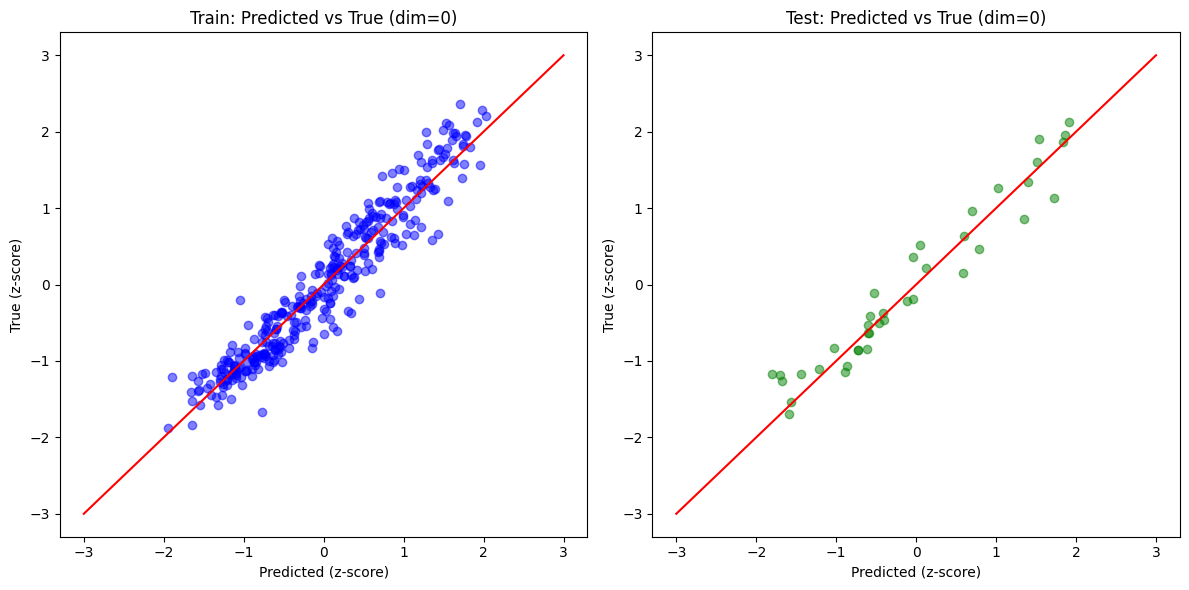

In [13]:
from sklearn.metrics import r2_score

r2 = r2_score(Y_test_pred, Y_test)
print(f"Pred R²: {r2}")

plt.figure(figsize=(12, 6))
# Training
plt.subplot(1, 2, 1)
plt.scatter(Y_train_pred[:, 0].cpu().numpy(), Y_train[:, 0].cpu().numpy(), color='blue', alpha=0.5)
plt.plot([-3,3], [-3,3], color='red')  
plt.title("Train: Predicted vs True (dim=0)")
plt.xlabel("Predicted (z-score)")
plt.ylabel("True (z-score)")

# Testing
plt.subplot(1, 2, 2)
plt.scatter(Y_test_pred[:, 0].cpu().numpy(), Y_test[:, 0].cpu().numpy(), color='green', alpha=0.5)
plt.plot([-3,3], [-3,3], color='red')
plt.title("Test: Predicted vs True (dim=0)")
plt.xlabel("Predicted (z-score)")
plt.ylabel("True (z-score)")

plt.tight_layout()
plt.show()

Running script main function

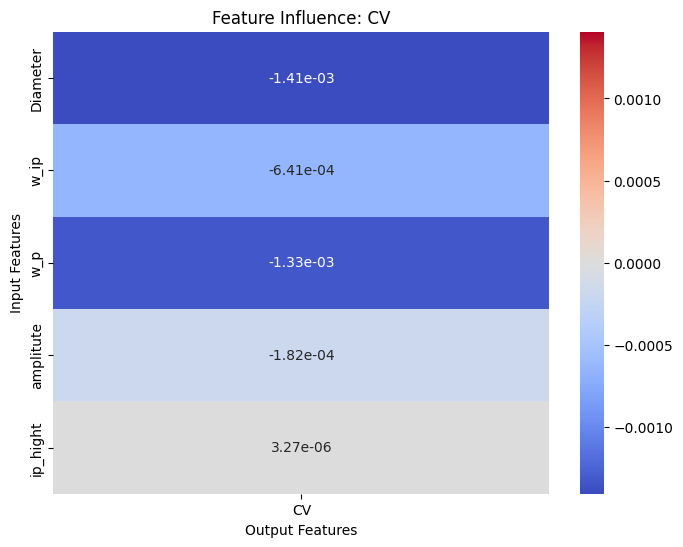

In [14]:
# input_name_list = df.columns[x_range].tolist()     # ["distance", "conduct_center", "conduct_around", "conduct_bulk"] ...
output_name_list = [df.columns[y_range]]#.tolist() # ["phi_cleft", "Na_pre", "Na_post"] ...

visualize_feature_influence(All_gradient_mat, input_name_list, output_name_list, f"Feature Influence: {model_type}")